In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
import ml_metrics as metrics

In [2]:
dtype={'is_booking':bool,
        'srch_ci' : np.str_,
        'srch_co' : np.str_,
        'srch_adults_cnt' : np.int32,
        'srch_children_cnt' : np.int32,
        'srch_rm_cnt' : np.int32,
        'srch_destination_id':np.str_,
        'user_location_country' : np.str_,
        'user_location_region' : np.str_,
        'user_location_city' : np.str_,
        'hotel_cluster' : np.str_,
        'orig_destination_distance':np.float64,
        'date_time':np.str_,
        'hotel_market':np.str_}
# feature selection
# downsample the data: 60% of the 2014 booking data
# originally have 30million training data, 3million test data, but only ~20 features,
# so we can down sample the data

#Specifying dtypes helps reduce memory requirements for reading in csv file later.

In [3]:
df0 = pd.read_csv('ExpediaData/train.csv',dtype=dtype, usecols=dtype, parse_dates=['date_time'] ,sep=',',nrows=2000000)

In [5]:
df0.head()

,date_time,user_location_country,user_location_region,user_location_city,orig_destination_distance,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,is_booking,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,66,348,48862,2234.2641,2014-08-27,2014-08-31,2,0,1,8250,False,628,1
1,2014-08-11 08:22:12,66,348,48862,2234.2641,2014-08-29,2014-09-02,2,0,1,8250,True,628,1
2,2014-08-11 08:24:33,66,348,48862,2234.2641,2014-08-29,2014-09-02,2,0,1,8250,False,628,1
3,2014-08-09 18:05:16,66,442,35390,913.1932,2014-11-23,2014-11-28,2,0,1,14984,False,1457,80
4,2014-08-09 18:08:18,66,442,35390,913.6259,2014-11-23,2014-11-28,2,0,1,14984,False,1457,21


In [6]:
# take data from 2014 as sampling 50%
df0['year']=df0['date_time'].dt.year
train = df0.query('is_booking==True & year==2014').sample(frac=0.6)
train.shape

(64532, 15)

In [7]:
train.tail()

,date_time,user_location_country,user_location_region,user_location_city,orig_destination_distance,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,is_booking,hotel_market,hotel_cluster,year
1000941,2014-08-31 22:46:49,66,153,23511,5859.1725,2014-09-11,2014-09-12,1,0,1,12715,True,160,5,2014
1264561,2014-02-05 16:11:08,66,153,5526,1272.0375,2014-02-12,2014-02-13,1,1,1,27699,True,646,16,2014
914692,2014-04-23 12:58:55,195,597,51774,NaN,2014-04-28,2014-04-29,1,0,1,22235,True,2,64,2014
738999,2014-01-28 18:44:59,66,462,49272,0.4421,2014-01-28,2014-01-29,2,0,1,12270,True,663,15,2014
72586,2014-07-31 22:42:22,66,462,49272,122.1952,2014-09-19,2014-09-22,2,2,1,8288,True,399,9,2014


In [8]:
train.isnull().sum(axis=0)

date_time                        0
user_location_country            0
user_location_region             0
user_location_city               0
orig_destination_distance    22009
srch_ci                          0
srch_co                          0
srch_adults_cnt                  0
srch_children_cnt                0
srch_rm_cnt                      0
srch_destination_id              0
is_booking                       0
hotel_market                     0
hotel_cluster                    0
year                             0
dtype: int64

# Feature Engineering

In [9]:
#datetime features
train['srch_ci']=pd.to_datetime(train['srch_ci'],infer_datetime_format = True,errors='coerce')
train['srch_co']=pd.to_datetime(train['srch_co'],infer_datetime_format = True,errors='coerce')

train['month']= train['date_time'].dt.month
train['plan_time'] = ((train['srch_ci']-train['date_time'])/np.timedelta64(1,'D')).astype(float)
train['hotel_nights']=((train['srch_co']-train['srch_ci'])/np.timedelta64(1,'D')).astype(float)

In [10]:
train.head()

,date_time,user_location_country,user_location_region,user_location_city,orig_destination_distance,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,is_booking,hotel_market,hotel_cluster,year,month,plan_time,hotel_nights
1205928,2014-01-10 21:09:40,66,337,44102,6848.8412,2014-01-24,2014-01-30,1,0,1,468,True,153,86,2014,1,13.118287,6.0
372805,2014-03-23 20:15:10,66,153,50542,8555.7580,2014-04-02,2014-04-03,1,0,1,8220,True,46,12,2014,3,9.156134,1.0
1700272,2014-05-03 21:33:53,66,174,47541,132.5384,2014-07-01,2014-07-04,2,2,1,12267,True,1230,28,2014,5,58.101470,3.0
50703,2014-10-29 22:56:43,119,0,27731,NaN,2015-02-19,2015-02-22,2,0,1,45348,True,821,58,2014,10,112.043947,3.0
901380,2014-11-29 10:03:25,133,26,36949,NaN,2015-02-08,2015-02-12,2,1,1,8785,True,35,8,2014,11,70.580961,4.0


In [12]:
#fill Missing Values

#fill orig_destination_distance with mean of the whole or mean of the same orig_destination pair
m=train.orig_destination_distance.mean()
train['orig_destination_distance']=train.orig_destination_distance.fillna(m)

#fill missing dates with -1
train.fillna(-1,inplace=True)

In [13]:
# Since we extract the plan_time from srch_ci and date_time, we drop date_time and srch_ci
# we extract how many nights of stay, so we drop srch_co
lst_drop=['date_time','srch_ci','srch_co']
train.drop(lst_drop,axis=1,inplace=True)

In [14]:
train.head()

,user_location_country,user_location_region,user_location_city,orig_destination_distance,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,is_booking,hotel_market,hotel_cluster,year,month,plan_time,hotel_nights
1205928,66,337,44102,6848.841200,1,0,1,468,True,153,86,2014,1,13.118287,6.0
372805,66,153,50542,8555.758000,1,0,1,8220,True,46,12,2014,3,9.156134,1.0
1700272,66,174,47541,132.538400,2,2,1,12267,True,1230,28,2014,5,58.101470,3.0
50703,119,0,27731,1717.129789,2,0,1,45348,True,821,58,2014,10,112.043947,3.0
901380,133,26,36949,1717.129789,2,1,1,8785,True,35,8,2014,11,70.580961,4.0


In [15]:
y=train['hotel_cluster']
X=train.drop(['hotel_cluster','is_booking','year'],axis=1) # in training dataset, have clicking and booking event

In [16]:
y.shape,X.shape

((64532,), (64532, 12))

In [19]:
y.nunique()

100

# Validation within sampled training set

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)

In [23]:
rf_tree = RandomForestClassifier(n_estimators=31,max_depth=10,random_state=123)
rf_tree.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=31, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [32]:
importance = rf_tree.feature_importances_

In [33]:
indices=np.argsort(importance)[::-1][:10]

In [34]:
importance[indices]

array([ 0.21982991,  0.17308166,  0.12056737,  0.09556621,  0.08182067,
        0.08025409,  0.0563725 ,  0.0526666 ,  0.05230889,  0.03135515])

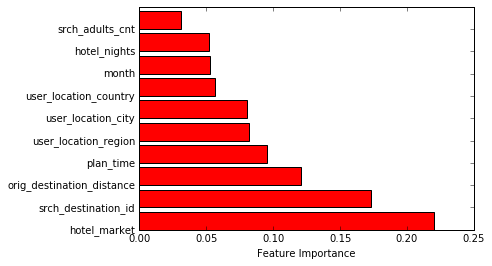

In [35]:
plt.barh(range(10), importance[indices],color='r')
plt.yticks(range(10),X_train.columns[indices])
plt.xlabel('Feature Importance')
plt.show()

In [36]:
rf_tree.classes_

array(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28',
       '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38',
       '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58',
       '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68',
       '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78',
       '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88',
       '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98',
       '99'], dtype=object)

In [37]:
dict_cluster = {}
for (k,v) in enumerate(rf_tree.classes_):
    dict_cluster[k] = v

In [38]:
dict_cluster

{0: '0',
 1: '1',
 2: '10',
 3: '11',
 4: '12',
 5: '13',
 6: '14',
 7: '15',
 8: '16',
 9: '17',
 10: '18',
 11: '19',
 12: '2',
 13: '20',
 14: '21',
 15: '22',
 16: '23',
 17: '24',
 18: '25',
 19: '26',
 20: '27',
 21: '28',
 22: '29',
 23: '3',
 24: '30',
 25: '31',
 26: '32',
 27: '33',
 28: '34',
 29: '35',
 30: '36',
 31: '37',
 32: '38',
 33: '39',
 34: '4',
 35: '40',
 36: '41',
 37: '42',
 38: '43',
 39: '44',
 40: '45',
 41: '46',
 42: '47',
 43: '48',
 44: '49',
 45: '5',
 46: '50',
 47: '51',
 48: '52',
 49: '53',
 50: '54',
 51: '55',
 52: '56',
 53: '57',
 54: '58',
 55: '59',
 56: '6',
 57: '60',
 58: '61',
 59: '62',
 60: '63',
 61: '64',
 62: '65',
 63: '66',
 64: '67',
 65: '68',
 66: '69',
 67: '7',
 68: '70',
 69: '71',
 70: '72',
 71: '73',
 72: '74',
 73: '75',
 74: '76',
 75: '77',
 76: '78',
 77: '79',
 78: '8',
 79: '80',
 80: '81',
 81: '82',
 82: '83',
 83: '84',
 84: '85',
 85: '86',
 86: '87',
 87: '88',
 88: '89',
 89: '9',
 90: '90',
 91: '91',
 92: '92

In [40]:
y_pred=rf_tree.predict_proba(X_test)
#take largest 5 probablities' indexes
a=y_pred.argsort(axis=1)[:,-5:]

In [44]:
y_pred

array([[ 0.00564825,  0.00124871,  0.00925157, ...,  0.01082044,
         0.01821786,  0.01924281],
       [ 0.00180321,  0.00052527,  0.01226696, ...,  0.0007038 ,
         0.00583644,  0.00532779],
       [ 0.00160761,  0.00017159,  0.00262477, ...,  0.00235252,
         0.00196019,  0.00654154],
       ..., 
       [ 0.00623391,  0.00771966,  0.00625676, ...,  0.01184139,
         0.04043595,  0.00781335],
       [ 0.00134521,  0.0033462 ,  0.00795571, ...,  0.0028752 ,
         0.01322009,  0.00790183],
       [ 0.0020493 ,  0.00133823,  0.00687791, ...,  0.00264975,
         0.00497309,  0.00697949]])

In [45]:
a

array([[61, 41, 38, 81, 59],
       [ 7, 37, 26, 91, 43],
       [64, 62, 59, 15, 81],
       ..., 
       [37, 52, 95, 98, 91],
       [70, 37, 10, 43, 91],
       [33, 37, 26, 91, 43]])

In [41]:
#take the corresonding cluster of the 5 top indices
b = []
for i in a.flatten():
    b.append(dict_cluster.get(i))

In [42]:
cluster_pred = np.array(b).reshape(a.shape)

In [43]:
cluster_pred

array([['64', '46', '43', '82', '62'],
       ['15', '42', '32', '91', '48'],
       ['67', '65', '62', '22', '82'],
       ..., 
       ['42', '56', '95', '98', '91'],
       ['72', '42', '18', '48', '91'],
       ['39', '42', '32', '91', '48']], 
      dtype='<U2')

In [21]:
print("score:",metrics.mapk(y_test,cluster_pred,k=5))

('score:', 0.083023807287753576)


In [58]:
metrics.mapk?

In [59]:
y_test.head()

1344684    22
1562876    13
126473     65
1116226    11
26545      38
Name: hotel_cluster, dtype: object

# Train on sampled training data and Predict on partial test data

In [46]:
#import and process test data
dtype1={'srch_ci' : np.str_,
        'srch_co' : np.str_,
        'srch_adults_cnt' : np.int32,
        'srch_children_cnt' : np.int32,
        'srch_rm_cnt' : np.int32,
        'srch_destination_id':np.str_,
        'user_location_country' : np.str_,
        'user_location_region' : np.str_,
        'user_location_city' : np.str_,
        'orig_destination_distance':np.float64,
        'date_time':np.str_,
        'hotel_market':np.str_}

In [49]:
# feature engineering on test data
test = pd.read_csv('ExpediaData/test.csv',dtype=dtype1,usecols=dtype1,parse_dates=['date_time'] ,sep=',')
test['srch_ci']=pd.to_datetime(test['srch_ci'],infer_datetime_format = True,errors='coerce')
test['srch_co']=pd.to_datetime(test['srch_co'],infer_datetime_format = True,errors='coerce')

test['month']=test['date_time'].dt.month
test['plan_time'] = ((test['srch_ci']-test['date_time'])/np.timedelta64(1,'D')).astype(float)
test['hotel_nights']=((test['srch_co']-test['srch_ci'])/np.timedelta64(1,'D')).astype(float)

n=test.orig_destination_distance.mean()
test['orig_destination_distance']=test.orig_destination_distance.fillna(m)
test.fillna(-1,inplace=True)


In [50]:
test1=test.sample(frac=0.05) # random sampled 5% of the test data

In [51]:
test1.shape, train.shape

((126412, 15), (64532, 15))

In [26]:
lst_drop=['date_time','srch_ci','srch_co']
test1.drop(lst_drop,axis=1, inplace=True)

In [52]:
target=train['hotel_cluster']
train1=train.drop(['hotel_cluster','is_booking','year'],axis=1)

In [33]:
train1.shape, test1.shape

((64532, 12), (126412, 12))

In [53]:
#on All training sample
rf_all = RandomForestClassifier(n_estimators=31,max_depth=10,random_state=123)
rf_all.fit(train1,target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=31, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

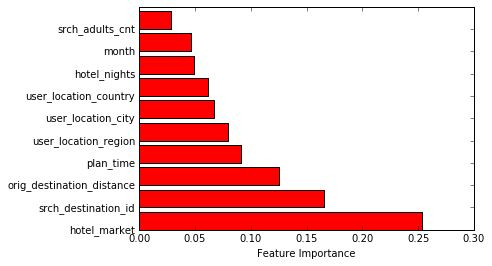

In [56]:
importance = rf_all.feature_importances_
indices=np.argsort(importance)[::-1][:10]
importance[indices]

plt.barh(range(10), importance[indices],color='r')
plt.yticks(range(10),train1.columns[indices])
plt.xlabel('Feature Importance')
plt.show()

In [ ]:
y_pred=rf_all.predict_proba(test1) # predict on test dataset

In [37]:
y_pred

array([[ 0.00308839,  0.00026104,  0.00825115, ...,  0.00291684,
         0.00532073,  0.00809091],
       [ 0.01228809,  0.00135506,  0.00775856, ...,  0.01887751,
         0.01015955,  0.02648091],
       [ 0.01020045,  0.00340528,  0.00681203, ...,  0.00740423,
         0.01982303,  0.00701485],
       ..., 
       [ 0.00305509,  0.        ,  0.00953475, ...,  0.00621128,
         0.00138713,  0.05696345],
       [ 0.01032881,  0.03660085,  0.01603377, ...,  0.01724432,
         0.03086507,  0.01196788],
       [ 0.00651711,  0.00016049,  0.00631528, ...,  0.00654724,
         0.00422   ,  0.01309574]])

In [38]:
#take largest 5 probablities' indexes
a=y_pred.argsort(axis=1)[:,-5:]

In [39]:
a

array([[38, 81, 43, 37, 91],
       [55, 99, 33, 61, 81],
       [46, 75, 37, 43, 91],
       ..., 
       [30, 59, 38, 99, 45],
       [31, 91, 36, 98,  1],
       [54, 57, 61, 92, 60]])

In [40]:
dict_cluster = {}
for (k,v) in enumerate(rf_tree.classes_):
    dict_cluster[k] = v

In [41]:
b = []
for i in a.flatten():
    b.append(dict_cluster.get(i))
predict_class=np.array(b).reshape(a.shape)

In [42]:
predict_class

array([['43', '82', '48', '42', '91'],
       ['59', '99', '39', '64', '82'],
       ['50', '77', '42', '48', '91'],
       ..., 
       ['36', '62', '43', '99', '5'],
       ['37', '91', '41', '98', '1'],
       ['58', '60', '64', '92', '63']], 
      dtype='|S2')

In [43]:
predict_class=map(lambda x: ' '.join(map(str,x)), predict_class)

In [44]:
predict_class

['43 82 48 42 91',
 '59 99 39 64 82',
 '50 77 42 48 91',
 '64 21 25 2 59',
 '71 91 98 56 70',
 '41 77 56 76 98',
 '59 82 36 64 2',
 '91 46 90 23 36',
 '43 62 80 67 82',
 '32 50 42 48 91',
 '59 82 97 46 64',
 '18 50 72 48 91',
 '65 96 0 21 26',
 '46 62 81 58 63',
 '58 59 29 64 46',
 '34 87 66 52 65',
 '43 37 48 82 36',
 '72 18 13 48 91',
 '82 2 58 78 21',
 '16 28 95 42 91',
 '82 36 58 46 59',
 '16 50 48 42 91',
 '32 28 42 48 91',
 '82 28 48 42 91',
 '32 28 48 42 91',
 '98 11 25 97 64',
 '32 7 48 42 91',
 '48 42 95 91 28',
 '9 64 70 56 98',
 '91 45 79 54 1',
 '67 43 46 62 82',
 '28 42 39 48 91',
 '39 82 42 48 91',
 '91 48 42 28 16',
 '30 67 85 62 82',
 '81 91 98 82 64',
 '41 48 18 42 91',
 '46 16 63 36 61',
 '85 91 82 48 61',
 '33 41 98 55 56',
 '20 59 90 68 4',
 '42 68 91 28 48',
 '72 18 95 48 91',
 '95 48 42 98 91',
 '37 29 59 64 2',
 '68 18 48 95 91',
 '58 46 5 82 15',
 '59 11 25 64 2',
 '2 25 64 98 59',
 '95 18 70 48 91',
 '59 62 46 64 82',
 '8 46 26 97 64',
 '46 9 64 29 2',
 '82 64 

In [ ]:
submission['hotel_cluster'] = predict_class
pd.tocsv['rf.cvs']

# Data Leakage Solution:
Referece: https://www.kaggle.com/zfturbo/expedia-hotel-recommendations/leakage-solution

In [ ]:
import datetime
from heapq import nlargest
from operator import itemgetter
from collections import defaultdict


def run_solution():
    print('Preparing arrays...')
    f = open("ExpediaData/train.csv", "r")
    f.readline()
    best_hotels_od_ulc = defaultdict(lambda: defaultdict(int))
    best_hotels_search_dest = defaultdict(lambda: defaultdict(int))
    best_hotels_search_dest1 = defaultdict(lambda: defaultdict(int))
    best_hotel_country = defaultdict(lambda: defaultdict(int))
    popular_hotel_cluster = defaultdict(int)
    total = 0

    # Calc counts
    while 1:
        line = f.readline().strip()
        total += 1

        if total % 10000000 == 0:
            print('Read {} lines...'.format(total))

        if line == '':
            break

        arr = line.split(",")
        book_year = int(arr[0][:4])
        user_location_city = arr[5]
        orig_destination_distance = arr[6]
        srch_destination_id = arr[16]
        is_booking = int(arr[18])
        hotel_country = arr[21]
        hotel_market = arr[22]
        hotel_cluster = arr[23]

        append_1 = 3 + 17*is_booking
        append_2 = 1 + 5*is_booking

        if user_location_city != '' and orig_destination_distance != '':
            best_hotels_od_ulc[(user_location_city, orig_destination_distance)][hotel_cluster] += 1

        if srch_destination_id != '' and hotel_country != '' and hotel_market != '' and book_year == 2014:
            best_hotels_search_dest[(srch_destination_id, hotel_country, hotel_market)][hotel_cluster] += append_1
        
        if srch_destination_id != '':
            best_hotels_search_dest1[srch_destination_id][hotel_cluster] += append_1
        
        if hotel_country != '':
            best_hotel_country[hotel_country][hotel_cluster] += append_2
        
        popular_hotel_cluster[hotel_cluster] += 1
    
    f.close()

    print('Generate submission...')
    now = datetime.datetime.now()
    path = 'submission_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
    out = open(path, "w")
    f = open("ExpediaData/test.csv", "r")
    f.readline()
    total = 0
    out.write("id,hotel_cluster\n")
    topclasters = nlargest(5, sorted(popular_hotel_cluster.items()), key=itemgetter(1))

    while 1:
        line = f.readline().strip()
        total += 1

        if total % 1000000 == 0:
            print('Write {} lines...'.format(total))

        if line == '':
            break

        arr = line.split(",")
        id = arr[0]
        user_location_city = arr[6]
        orig_destination_distance = arr[7]
        srch_destination_id = arr[17]
        hotel_country = arr[20]
        hotel_market = arr[21]

        out.write(str(id) + ',')
        filled = []

        s1 = (user_location_city, orig_destination_distance)
        if s1 in best_hotels_od_ulc:
            d = best_hotels_od_ulc[s1]
            topitems = nlargest(5, sorted(d.items()), key=itemgetter(1))
            for i in range(len(topitems)):
                if topitems[i][0] in filled:
                    continue
                if len(filled) == 5:
                    break
                out.write(' ' + topitems[i][0])
                filled.append(topitems[i][0])

        s2 = (srch_destination_id, hotel_country, hotel_market)
        if s2 in best_hotels_search_dest:
            d = best_hotels_search_dest[s2]
            topitems = nlargest(5, d.items(), key=itemgetter(1))
            for i in range(len(topitems)):
                if topitems[i][0] in filled:
                    continue
                if len(filled) == 5:
                    break
                out.write(' ' + topitems[i][0])
                filled.append(topitems[i][0])
        elif srch_destination_id in best_hotels_search_dest1:
            d = best_hotels_search_dest1[srch_destination_id]
            topitems = nlargest(5, d.items(), key=itemgetter(1))
            for i in range(len(topitems)):
                if topitems[i][0] in filled:
                    continue
                if len(filled) == 5:
                    break
                out.write(' ' + topitems[i][0])
                filled.append(topitems[i][0])

        if hotel_country in best_hotel_country:
            d = best_hotel_country[hotel_country]
            topitems = nlargest(5, d.items(), key=itemgetter(1))
            for i in range(len(topitems)):
                if topitems[i][0] in filled:
                    continue
                if len(filled) == 5:
                    break
                out.write(' ' + topitems[i][0])
                filled.append(topitems[i][0])

        for i in range(len(topclasters)):
            if topclasters[i][0] in filled:
                continue
            if len(filled) == 5:
                break
            out.write(' ' + topclasters[i][0])
            filled.append(topclasters[i][0])

        out.write("\n")
    out.close()
    print('Completed!')

run_solution()

Preparing arrays...
Read 10000000 lines...
